In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import optuna

In [3]:
BATCHSIZE = 64
EPOCHS = 100
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
train_data = torchvision.datasets.CIFAR10("./dataset/train/", train=True, download=False, transform=ToTensor())
test_data = torchvision.datasets.CIFAR10("./dataset/test/", train=False, download=False, transform=ToTensor())

train_loader = DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCHSIZE)

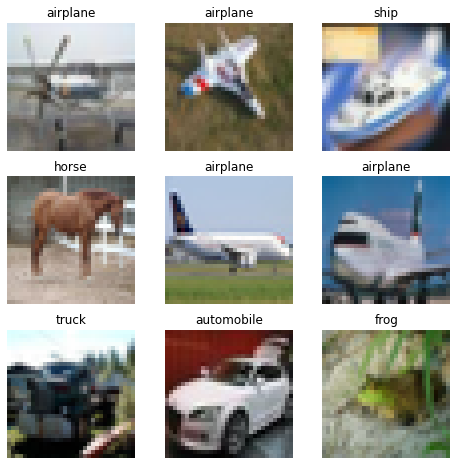

In [4]:
labels_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    pil = torchvision.transforms.ToPILImage()
    img = pil(img)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [176]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3)
    self.fc1 = nn.Linear(26*26, 50)
    self.fc2 = nn.Linear(50, 10)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 26*26)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)
    return x
model = CNN().to(device)

# optimizer tuning

In [15]:
def objective(trial: optuna.Trial):
    momentum = trial.suggest_float("momentum", 0.9, 0.999)
    lr = trial.suggest_float("lr", 1e-6, 1e-2)
    alpha = trial.suggest_float("alpha", 0.9, 0.999)
    eps = trial.suggest_float("eps", 1e-8, 1e-4)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr, momentum, alpha, eps)
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.view(-1, 3*32*32).to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.view(-1, 32*32*3).to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
        accuracy = correct / len(test_loader.dataset)
        return accuracy
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-05-16 22:56:01,977] A new study created in memory with name: no-name-1b75ef6a-efba-408c-a9e1-dc9fc51f8900
[I 2024-05-16 22:56:09,133] Trial 0 finished with value: 0.2853 and parameters: {'momentum': 0.9730654414054295, 'lr': 0.009324375514589978, 'alpha': 0.9984228380659388, 'eps': 6.581364650650027e-05}. Best is trial 0 with value: 0.2853.
[I 2024-05-16 22:56:16,231] Trial 1 finished with value: 0.3226 and parameters: {'momentum': 0.9089932482891581, 'lr': 0.008128409795241726, 'alpha': 0.9630052202988241, 'eps': 4.904869432667504e-05}. Best is trial 1 with value: 0.3226.
[I 2024-05-16 22:56:23,349] Trial 2 finished with value: 0.346 and parameters: {'momentum': 0.9478277953145876, 'lr': 0.00826075738629997, 'alpha': 0.9432497499481627, 'eps': 1.887749710418375e-06}. Best is trial 2 with value: 0.346.
[W 2024-05-16 22:56:25,877] Trial 3 failed with parameters: {'momentum': 0.9088650546580298, 'lr': 0.0025133861911189985, 'alpha': 0.9133755383389024, 'eps': 4.2041460871689905e-

KeyboardInterrupt: 

# loss_function tuning

In [212]:
def objective(trial: optuna.Trial):
    loss_trial = trial.suggest_categorical('loss_fn',['KLDivLoss', 'HuberLoss', 'L1Loss', 'SmoothL1Loss'])
    loss_fn = getattr(nn, loss_trial)()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            out, _ = torch.max(output, dim=1)
            loss = loss_fn(out, target.float())
            loss.backward()
            optimizer.step()
        return loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-05-18 15:23:39,753] A new study created in memory with name: no-name-b1c637db-fe93-416b-a98f-1066ccd91ad9
[I 2024-05-18 15:23:46,881] Trial 0 finished with value: 3.6875 and parameters: {'loss_fn': 'L1Loss'}. Best is trial 0 with value: 3.6875.
[I 2024-05-18 15:23:53,991] Trial 1 finished with value: 4.2316083908081055 and parameters: {'loss_fn': 'KLDivLoss'}. Best is trial 0 with value: 3.6875.
[I 2024-05-18 15:24:01,061] Trial 2 finished with value: 3.8977622985839844 and parameters: {'loss_fn': 'KLDivLoss'}. Best is trial 0 with value: 3.6875.
[I 2024-05-18 15:24:08,151] Trial 3 finished with value: 2.416019916534424 and parameters: {'loss_fn': 'KLDivLoss'}. Best is trial 3 with value: 2.416019916534424.
[I 2024-05-18 15:24:15,219] Trial 4 finished with value: 4.375 and parameters: {'loss_fn': 'SmoothL1Loss'}. Best is trial 3 with value: 2.416019916534424.
[I 2024-05-18 15:24:22,276] Trial 5 finished with value: 4.25 and parameters: {'loss_fn': 'L1Loss'}. Best is trial 3 wit

KeyboardInterrupt: 

In [9]:
result_lossfn = study.trials_dataframe()
#result_lossfn.to_csv("./optuna_lossfn.csv")
result_lossfn.head()

,number,value,datetime_start,datetime_complete,duration,params_loss_fn,state
0,0,0.1,2024-05-16 22:44:36.364150,2024-05-16 22:44:42.944264,0 days 00:00:06.580114,MSELoss,COMPLETE
1,1,0.1,2024-05-16 22:44:42.945730,2024-05-16 22:44:49.652236,0 days 00:00:06.706506,L1Loss,COMPLETE
2,2,NaN,2024-05-16 22:44:49.653272,2024-05-16 22:44:55.870798,0 days 00:00:06.217526,KLDivLoss,FAIL
